# Next frame prediction

The project consists of predicting the next frame in a short movie sequence.

For this project, we shall use the Moving MNIST dataset, composed of 10,000 video sequences, each consisting of 20 frames. In each video sequence, two digits move independently around the frame, which has a spatial resolution of 64×64 pixels. The digits frequently intersect with each other and bounce off the edges of the frame.

While each sequence has a lenght of 20, your are supposed to use **only 3 consecutive frames as input**, and **predict the next one**.

The metric used to evalaute the quality of the predicted frame is Mean Squared Error.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers

import math
import matplotlib.pyplot as plt
import numpy as np

import os

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox



In [ ]:
ds = tfds.as_numpy(tfds.load(
    'moving_mnist',
    split='test',
    batch_size=-1
))
sequences = ds['image_sequence']

The dataset is composed of 10000 sequences of 20 frames each. Each (grayscale) frame has dimnesion 64x64

In [ ]:
sequences = np.squeeze(np.swapaxes(sequences, 1, 4),axis=1)/255.
print(sequences.shape)
print(np.min(sequences),np.max(sequences))

(10000, 64, 64, 20)
0.0 1.0


Let us split the dataset in training, validation and testing.
You are supposed to evaluate the performance of your model using MSE over the full test set.

In [ ]:
trainset = sequences[:8000]
valset = sequences[8000:9000]
testset = sequences[8000:9000]

Here is a simple generator, creating the input sequences of 3 frames, and the expected output, namely the next frame.

In [ ]:
def image_generator(dataset,batchsize=16,seqlen=4):
    while True:
      batch_x = np.zeros((batchsize,64,64,seqlen-1))
      batch_y = np.zeros((batchsize,64,64,1))
      ran = np.random.randint(dataset.shape[0],size=batchsize)
      minibatch = dataset[ran]
      #these sequences have length 20; we reduce them to seqlen
      for i in range(batchsize):
          random_start = np.random.randint(0,20-seqlen)
          random_end = random_start+seqlen-1
          batch_x[i] = minibatch[i,:,:,random_start:random_end]
          batch_y[i] = minibatch[i,:,:,random_end:random_end+1]
          yield(batch_x,batch_y)

In [ ]:
prova_gen = image_generator(testset,batchsize=1,seqlen=4)

In [ ]:
sample_x, sample_y = next(prova_gen)

In [ ]:
print(type(sample_x))

<class 'numpy.ndarray'>


In [ ]:
def show_list(images): #takes in input a list of images and plot them
    size = len(images)
    plt.figure(figsize=(10, 10 * size))
    for i in range(size):
        plt.subplot(1, size, i + 1)
        plt.imshow(images[i],cmap='gray',)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

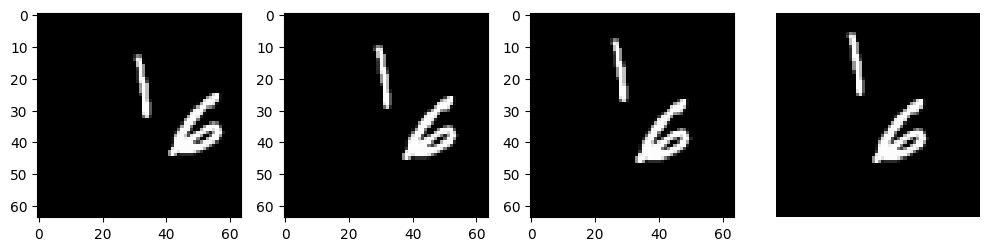

In [ ]:
all = [sample_x[0,:,:,i] for i in range(3)]+[sample_y[0,:,:,0]]
show_list(all)

In [ ]:
train_gen = image_generator(trainset)
val_gen = image_generator(valset)
test_gen = image_generator(valset)

In [ ]:
sample_x, sample_y = next(train_gen)

# My implementation of the solution starts **FROM HERE**

## **Create the model**



For this task, I built a model that has  three consecutive **ConvLSTM** layers, all  with a BatchNormalization layer at the end, and then a **Conv2D** layer that outputs the next frame predicted image.

The reason why I used **ConvLSTM** layers is that it is suitable for tasks in which there are **sequential images** as input data, like in this case.

A **ConvLSTM** layer is a **Recurrent layer**, just like the LSTM, but internal matrix multiplications are exchanged with **convolution operations**.

The input of a ConvLSTM must be a set of images over time as a 5D tensor with shape (samples, time_steps, rows, cols, channels).
In our case we have that:
- **samples = batch size**
- **time_steps = 3**, because we need 3 consecutive frames
- **rows = cols = 64**, because 64x64 is the size of an image in the dataset
- **channels = 1**, because images are gray images (no rgb channels)

The output of the network is of the shape (batch_size, 64, 64, 1): it outputs the next predicted frame for each element in the batch_size.

Note that the current shape of the **data** generated from *train_gen* (the same goes for *val_gen* and *test_gen*) is (batch_size, 64, 64, 3).

In [ ]:
print(sample_x.shape)

(16, 64, 64, 3)


As we said we need data with shape (samples, time_steps, rows, cols, channels); in order to achieve this I implemented a preprocessing method on **x data**.

In [ ]:
def preprocess_data(x):
    # add another dimension for the gray channel
    x = np.expand_dims(x, axis= 4)
    # change from (batch_size, 64, 64, 3, 1) to (batch_size, 64, 3, 64, 1)
    x = np.swapaxes(x, 3, 2)
    # change from (batch_size, 64, 3, 64, 1) to (batch_size, 3, 64, 64, 1)
    x = np.swapaxes(x, 2, 1)
    return x

In [ ]:
sample_x = preprocess_data(sample_x)
# now sample_x is of the right shape
print(sample_x.shape)

(16, 3, 64, 64, 1)


Below there is the implementation of the model via  the **functional API**.

It's important to remember that the ConvLSTM layer output is a combination of a Convolution and a LSTM output. If **return_sequences = True**, then it returns a sequence as a 5D tensor with shape (samples, time_steps, rows, cols, filters). On the other hand, if **return_sequences = False**, then it returns only the last value of the sequence as a 4D tensor with shape (samples, rows, cols, filters).

In [ ]:
input_shape = sample_x.shape[1:]
# Input layer has shape (None, 3, 64, 64, 1)
inp = layers.Input(shape=input_shape)

# As follows there are 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv2D` layer

# return_sequences is true so it will output (None, 3, 64, 64, 64)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
# return_sequences is true so it will output (None, 3, 64, 64, 64) as before
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
# return_sequences is true so it will output (None, 64, 64, 64)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=False,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
# it outputs (None, 64, 64, 1)
x = layers.Conv2D(
    filters=1, kernel_size=(3, 3), activation="sigmoid", padding="same"
)(x)

# Next, I build the complete model and compile it
model = keras.models.Model(inp, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 64, 64, 1)]    0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 3, 64, 64, 64)     416256    
                                                                 
 batch_normalization (BatchN  (None, 3, 64, 64, 64)    256       
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 3, 64, 64, 64)     295168    
                                                                 
 batch_normalization_1 (Batc  (None, 3, 64, 64, 64)    256       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 64, 64, 64)        33024 

# Train the model

I decided to build the training loop and the evaluation loop from scratch, along with computation of metrics and generation of history.

- **train_step**, given the **x batch of data** and the **y ground truth batch**, computes the next **predicted image** and computes the loss value by calling the loss function. Then it computes the gradients with respect to the model paratemets and performs a gradient descent step following the optimizer inner implementation. It also updates the train metrics of the model.

- **val_step**, given the **x batch of data** and the **y ground truth batch**, computes the next **predicted image** and computes the loss value by calling the loss function as before. There is no train here, Both the metric and the loss_tracker are updated.

- **test_step**, same as val_step but with the difference that there is no loss_tracker and that the predicted frames are returned.

I inserted the decorator @tf.function because it compiles a function into a callable TensorFlow graph and this speeds up the computation.


In [ ]:
@tf.function
def train_step(x, y, model, loss_fn, optimizer, train_loss_tracker, train_metric):
  with tf.GradientTape() as tape:
      # feedforward step
      predicted_frames = model(x, training=True)
      # calculate the loss
      loss_value = loss_fn(y, predicted_frames)
  # calculate gradients with respect to all the trainable model weights
  grads = tape.gradient(loss_value, model.trainable_weights)
  # applies a gradient descent step following the internal update of the optimizer
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
  # updates the train loss tracker and  metric
  train_loss_tracker.update_state(loss_value)
  train_metric.update_state(y, predicted_frames)
  return loss_value

@tf.function
def val_step(x, y, model, loss_fn, val_loss_tracker, val_metric):
  # feedforward step
  predicted_frames = model(x, training=False)
  # calculate the loss
  loss_value = loss_fn(y, predicted_frames)
  # updates the validation loss tracker and metric
  val_loss_tracker.update_state(loss_value)
  val_metric.update_state(y, predicted_frames)

@tf.function
def test_step(x, y, model, metric):
    # feedforward step
    predicted_frames = model(x, training=False)
    # updates the test metric
    metric.update_state(y, predicted_frames)
    return predicted_frames

Then I built from scratch all the training loop in which I also implemented an **early stopping strategy**.

In [ ]:
def training_loop(model, loss_fn, optimizer, train_generator, val_dataset, loss_tracker,  patience = 5, epochs = 30, steps_per_epoch = 20):
    # initialize wait and best loss for early stopping strategy
    wait = 0
    best_loss = float('inf')
    best_weights = model.get_weights()
    # the metric used is mse
    metric = tf.keras.metrics.MeanSquaredError()
    print("Start of training ")
    dict_to_return = {'loss': [], 'val_loss' : [], 'accuracy' :[], 'val_accuracy' : []}
    for epoch in range(epochs):

        for step in range(steps_per_epoch):
            # generates x batch and y batch through the train generator
            x_batch, y_batch = next(train_generator)
            # preprocesses x batch to have shape equal to input shape of the network
            x_batch = preprocess_data(x_batch)
            # performs a training step
            loss_value = train_step(x_batch, y_batch, model, loss_fn, optimizer, loss_tracker, metric)
            # every 10 steps it prints the number of seen training data
        # retrieves the final values of train loss value and train metric value at the end of the epoch
        loss_value_train = loss_tracker.result().numpy()
        metric_result_train = metric.result().numpy()
        # resets loss tracker and metric for the next epoch
        loss_tracker.reset_states()
        metric.reset_states()

        # gets x batch and y batch from validation dataset
        for x_batch_val, y_batch_val in val_dataset:
            # performs a a validation step
            val_step(x_batch_val, y_batch_val, model, loss_fn, loss_tracker, metric)
        # retrieves the  values of validation loss value and validation metric value
        loss_value_val = loss_tracker.result().numpy()
        metric_result_val = metric.result().numpy()
        # resets validation loss tracker and validation metric for the next epoch
        loss_tracker.reset_states()
        metric.reset_states()
        # adds to the history the values retrieved from train metric value, train loss value
        # validation metric value and validation loss value
        dict_to_return['accuracy'].append(metric_result_train)
        dict_to_return['loss'].append(loss_value_train)
        dict_to_return['val_accuracy'].append(metric_result_val)
        dict_to_return['val_loss'].append(loss_value_val)
        print("EPOCH {0} --- LOSS value : {1}, MSE value : {2}, val LOSS value : {3}, val MSE value : {4} ".format(epoch, loss_value_train, metric_result_train, loss_value_val, metric_result_val))
        # The early stopping strategy: stop the training if `val_loss` does not
        # decrease over a certain number of epochs
        wait += 1
        if loss_value_val < best_loss:
          best_loss = loss_value_val
          best_weights = model.get_weights()
          wait = 0
        if wait >= patience:
          model.set_weights(best_weights)
          print("Learning interrupted because of Early Stopping at epoch {}".format(epoch))
          break
    return dict_to_return

I defined a method in order to generate a dataset from  **number of batches** and a **generator**. This method is used for creating validation and test datasets.

In [ ]:
def create_dataset(n_batches, gen_generator):
    x, y= [], []
    for i in range(n_batches):
        # generates the batch from the generator
        x_batch, y_batch = next(gen_generator)
        # preprocesses the x batch data
        x_batch = preprocess_data(x_batch)
        # appends the batch to the list of batches for both data and targets
        x.append(x_batch)
        y.append(y_batch)
    x = np.array(x)
    y = np.array(y)
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    return dataset

- The loss function used is the **mean squared logarithmic error**
- the metric is the** mean squared error**
- the optimizer used is Adam optimizer with learning rate = 0.001


In [ ]:
loss_fn = tf.keras.losses.mean_squared_logarithmic_error
loss_tracker = tf.keras.metrics.Mean()
steps_per_epoch = 225
val_num_batches = 30
test_num_batches = 30
batch_size = 32
lr = 0.001
patience = 8
epochs = 30
optimizer = keras.optimizers.Adam(lr)
train_gen = image_generator(trainset,batch_size)
val_gen = image_generator(valset,batch_size)
val_dataset = create_dataset(val_num_batches, val_gen)
test_dataset = create_dataset(test_num_batches, val_gen)

In [ ]:
history = training_loop(model, loss_fn, optimizer, train_gen, val_dataset, loss_tracker, patience, epochs, steps_per_epoch)

Start of training 
EPOCH 0 --- LOSS value : 0.017197491601109505, MSE value : 0.03140503540635109, val LOSS value : 0.44339826703071594, val MSE value : 0.919967532157898 
EPOCH 1 --- LOSS value : 0.005189492832869291, MSE value : 0.010452616959810257, val LOSS value : 0.43012911081314087, val MSE value : 0.8927706480026245 
EPOCH 2 --- LOSS value : 0.004527610260993242, MSE value : 0.009264013729989529, val LOSS value : 0.07925654202699661, val MSE value : 0.11788488924503326 
EPOCH 3 --- LOSS value : 0.004262151662260294, MSE value : 0.008728820830583572, val LOSS value : 0.03512871265411377, val MSE value : 0.05158273130655289 
EPOCH 4 --- LOSS value : 0.00418320344761014, MSE value : 0.008577132597565651, val LOSS value : 0.008925377391278744, val MSE value : 0.01802223175764084 
EPOCH 5 --- LOSS value : 0.004140503704547882, MSE value : 0.008507070131599903, val LOSS value : 0.009133296087384224, val MSE value : 0.019507944583892822 
EPOCH 6 --- LOSS value : 0.0041246176697313786,

# Test the model

In [ ]:
test_metric = tf.keras.metrics.MeanSquaredError()
for x_batch_test, y_batch_test in test_dataset:
      # performs a test step
      test_step(x_batch_test, y_batch_test, model, test_metric)
# gets the mse result on all the test set
test_mse = test_metric.result()
test_metric.reset_states()
print("Mean Squared Error (mse) value computed on all the test dataset: {0}".format(test_mse.numpy()))

Mean Squared Error (mse) value computed on all the test dataset: 0.015838822349905968


I created plots from history:
- The first compares **train and validation mse**  (which is the metric used) over epochs.
- The second one compares **train and validation losses** over epochs.

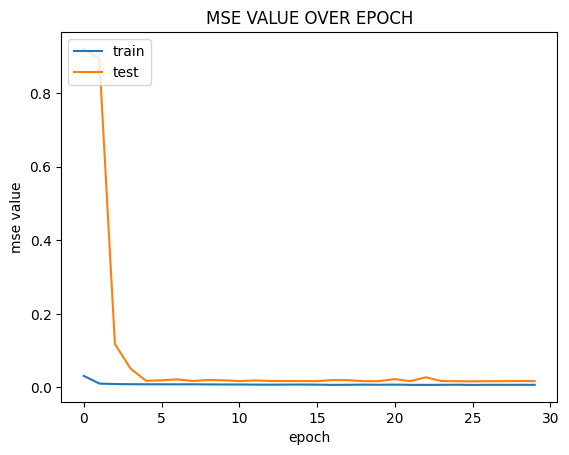

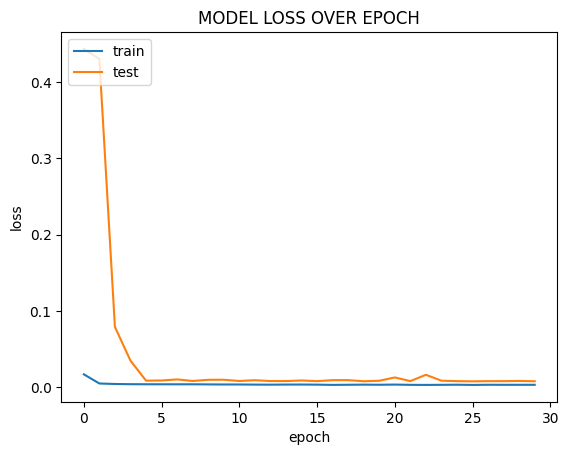

In [ ]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('MSE VALUE OVER EPOCH')
plt.ylabel('mse value')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('MODEL LOSS OVER EPOCH')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Observe results of the model

Here I compare original images, taken from the test dataset, with images predicted by the network.

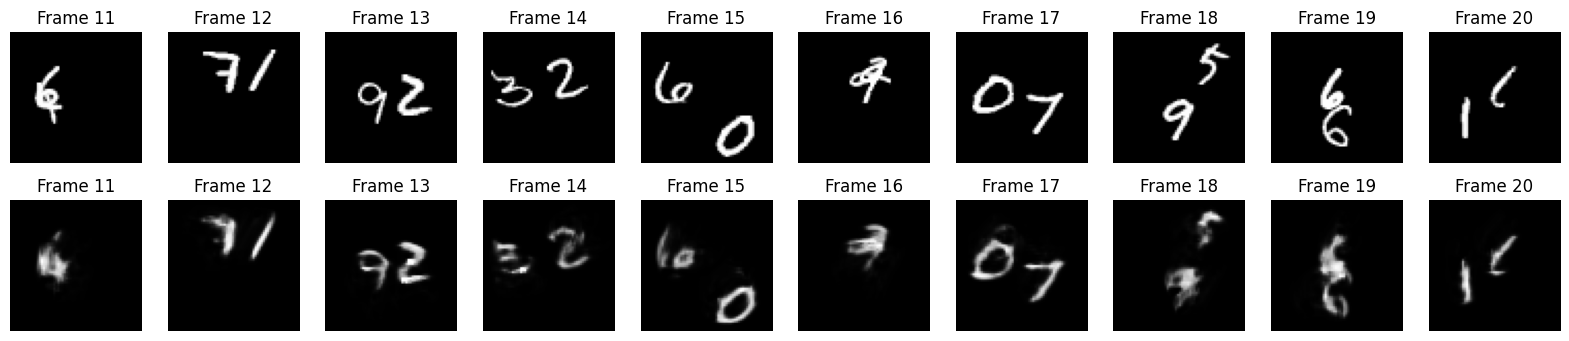

In [ ]:
x_test_b, y_test_b = next(test_dataset.as_numpy_iterator())
# performs forward step
y_pred = model(x_test_b, training=False)
# takes the first 10 frames from both original images and predicted images
y_pred = y_pred[:10]
y_test_b = y_test_b[:10]

# Construct a figure for the original and new frames
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
# Plot the original frames
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(y_test_b[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(y_pred[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

In this last section I compare **videos** of the original image frames with videos of the predicted frames.

In [ ]:
seqlen = 4
num_comparisons = 5
xs = np.zeros((num_comparisons, 10, 64,64, seqlen-1))
ys = np.zeros((num_comparisons, 10, 64,64,1))
# Select 5 random examples from the dataset.
rands = np.random.choice(range(len(testset)), size=num_comparisons)
test_instance = testset[rands]
for i in range(num_comparisons):
  for j in range(10):
      xs[i][j] = test_instance[i, :, :, j:j+seqlen-1]
      ys[i][j] = test_instance[i, :, :, j+seqlen-1:j+seqlen]
predicted_videos = []
xs_preprocessed_xs = np.ones((num_comparisons, 10, 3, 64, 64, 1))
for i in range(num_comparisons):
  xs_preprocessed = preprocess_data(xs[i])
  xs_preprocessed_xs[i] = xs_preprocessed


predicted_videos = []
ys_prediction = np.zeros((num_comparisons, 10, 64,64,1))

import cv2

# Iterate over the examples and predict the frames.
for i in range(num_comparisons):
  ys_prediction[i] = model.predict(xs_preprocessed_xs[i])

# Create and save GIFs for each of the ground truth/prediction images.
for i in range(num_comparisons):
  for frame_set in [ys, ys_prediction]:
      current_frames = np.squeeze(frame_set)
      current_frames = (current_frames * 255).astype(np.uint8)
      # Construct a GIF from the frames.
      with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames[i], "GIF", fps=5)
            predicted_videos.append(gif.getvalue())



# Display the videos.
print(len(predicted_videos))
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 0s 34ms/step
10
 Truth	Prediction
